# Team
# Name : Muhammad Khubaib Akram
# ID : 23098929
# Name : Vilohit Keshava Murthy Achar
# ID : 23077751
# Name : Mohit Chandrashekhar Attarde
# ID : 23241977

The code executes completely without any error

# CS6482 Deep Reinforcement Learning Assignment 3: DQN for Atari (BreakoutNoSkip-v4)


# References:

DQN implemenation:  https://keras.io/examples/rl/deep_q_network_breakout/

Dueling Implementation:  https://github.com/yilundu/DQN-DDQN-on-Space-Invaders

Prioritized Replay Buffer:  https://github.com/XinJingHao/Prioritized-Experience-Replay-DDQN-Pytorch


# Gym Setup

In [1]:
!pip install gymnasium['atari, accept-rom-license']

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 47.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.2 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=06f2920593e14bdea5d09070f67f6e9c8f229c4744e371bec68655356cb49b35
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [2]:
import gymnasium as gym
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStack
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# List all available environments
envs = gym.envs.registry
env_ids = list(envs.keys())

# Filter for Atari environments
atari_envs = [env_id for env_id in env_ids if 'Atari' in env_id or 'NoFrameskip' in env_id]

# Print Atari environments
print("Available Atari environments:")
for env_id in atari_envs:
    print(env_id)

# Check for a specific Atari environment
specific_env = 'BreakoutNoFrameskip-v4'  # Replace with the specific Atari environment ID you are looking for
if specific_env in env_ids:
    print(f"{specific_env} is available in Gymnasium.")
else:
    print(f"{specific_env} is not available in Gymnasium.")


Available Atari environments:
AdventureNoFrameskip-v0
AdventureNoFrameskip-v4
Adventure-ramNoFrameskip-v0
Adventure-ramNoFrameskip-v4
AirRaidNoFrameskip-v0
AirRaidNoFrameskip-v4
AirRaid-ramNoFrameskip-v0
AirRaid-ramNoFrameskip-v4
AlienNoFrameskip-v0
AlienNoFrameskip-v4
Alien-ramNoFrameskip-v0
Alien-ramNoFrameskip-v4
AmidarNoFrameskip-v0
AmidarNoFrameskip-v4
Amidar-ramNoFrameskip-v0
Amidar-ramNoFrameskip-v4
AssaultNoFrameskip-v0
AssaultNoFrameskip-v4
Assault-ramNoFrameskip-v0
Assault-ramNoFrameskip-v4
AsterixNoFrameskip-v0
AsterixNoFrameskip-v4
Asterix-ramNoFrameskip-v0
Asterix-ramNoFrameskip-v4
AsteroidsNoFrameskip-v0
AsteroidsNoFrameskip-v4
Asteroids-ramNoFrameskip-v0
Asteroids-ramNoFrameskip-v4
AtlantisNoFrameskip-v0
AtlantisNoFrameskip-v4
Atlantis-ramNoFrameskip-v0
Atlantis-ramNoFrameskip-v4
BankHeistNoFrameskip-v0
BankHeistNoFrameskip-v4
BankHeist-ramNoFrameskip-v0
BankHeist-ramNoFrameskip-v4
BattleZoneNoFrameskip-v0
BattleZoneNoFrameskip-v4
BattleZone-ramNoFrameskip-v0
BattleZone-

# Wrapper

In [3]:
from gym.core import Wrapper
from gym.spaces.box import Box
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def observation(self, img):
        """what happens to each observation"""

        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img = img[34:-16, 8:-8, :]
        img = cv2.resize(img, self.img_size[1:])
        img = (img*np.array([[[0.8, .1, .1]]])).sum(-1, keepdims=True)  # grayscale with more weight for red (accelerates training)
        img = img.astype('float32') / 255.
        return img.transpose((2, 0, 1))

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        terminated = None
        for i in range(self._skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if terminated:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, terminated, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs,reward, terminated, truncated, info = self.env.step(1)
        if terminated:
            self.env.reset(**kwargs)
        obs,reward, terminated, truncated, info = self.env.step(2)
        if terminated:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.was_real_done = terminated
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            terminated = True
        self.lives = lives
        return obs, reward, terminated, truncated, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, reward, terminated, truncated, info = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

def PrimaryAtariWrap(env, clip_rewards=True):
    # assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = ClipRewardEnv(env)

    # This wrapper preprocesses observations
    env = PreprocessAtariObs(env)
    return env

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, terminated, truncated, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, terminated, truncated, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)


def make_env(clip_rewards=True, seed=None):
    env = gym.make('BreakoutNoFrameskip-v4')  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

# DQN

In [4]:
# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = epsilon_max - epsilon_min  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000
max_episodes = 500 #500 # Limit training episodes, will run until solved if smaller than 1

# Use the Atari environment
env = gym.make("BreakoutNoFrameskip-v4")
env = AtariPreprocessing(env)
env = FrameStack(env, 4)
env.seed(seed)

num_actions = 4

def create_q_model():
    # Network defined by the Deepmind paper
    return keras.Sequential(
        [
            layers.Lambda(
                lambda tensor: tf.transpose(tensor, [0, 2, 3, 1]),
                output_shape=(84, 84, 4),
                input_shape=(4, 84, 84),
            ),
            # Convolutions on the frames on the screen
            layers.Conv2D(32, 8, strides=4, activation="elu", input_shape=(4, 84, 84)),
            layers.Conv2D(64, 4, strides=2, activation="elu"),
            layers.Conv2D(64, 3, strides=1, activation="elu"),
            layers.Flatten(),
            layers.Dense(1024, activation="elu"),
            layers.Dropout(0.1),
            layers.Dense(num_actions, activation="linear"),
        ]
    )

# The first model makes the predictions for Q-values which are used to make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
model_target = create_q_model()

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

rewards_over_episodes = []
q_values_over_episodes = []
losses_over_episodes = []  # List to store the average loss per episode

while True:
    observation, _ = env.reset()
    state = np.array(observation)
    episode_reward = 0
    episode_loss = []  # List to store loss for the current episode

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])

            # Build the updated Q-values for the sampled future states
            future_rewards = model_target.predict(state_next_sample, verbose=0)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # Store the loss value
            episode_loss.append(loss.numpy())


        if frame_count % update_target_network == 0:
            # update the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    rewards_over_episodes.append(episode_reward)
    q_values_over_episodes.append(tf.reduce_mean(q_action).numpy())
    losses_over_episodes.append(np.mean(episode_loss))  # Store the average loss for this episode


    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

    if max_episodes > 0 and episode_count >= max_episodes:  # Maximum number of episodes reached
        print("Stopped at episode {}!".format(episode_count))
        break






/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


running reward: 1.13 at episode 53, frame count 10000
running reward: 1.22 at episode 107, frame count 20000
running reward: 1.25 at episode 160, frame count 30000
running reward: 1.58 at episode 208, frame count 40000
running reward: 1.59 at episode 261, frame count 50000
running reward: 1.33 at episode 314, frame count 60000
running reward: 1.29 at episode 367, frame count 70000
running reward: 1.29 at episode 421, frame count 80000
running reward: 1.19 at episode 477, frame count 90000
Stopped at episode 500!


## Results

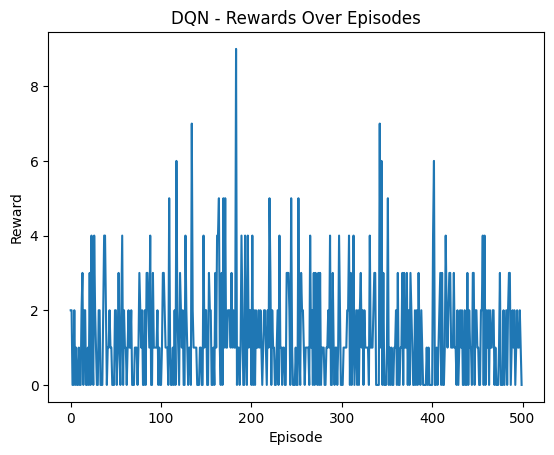

In [5]:
# Plotting rewards over episodes
plt.plot(rewards_over_episodes)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN - Rewards Over Episodes')
plt.show()

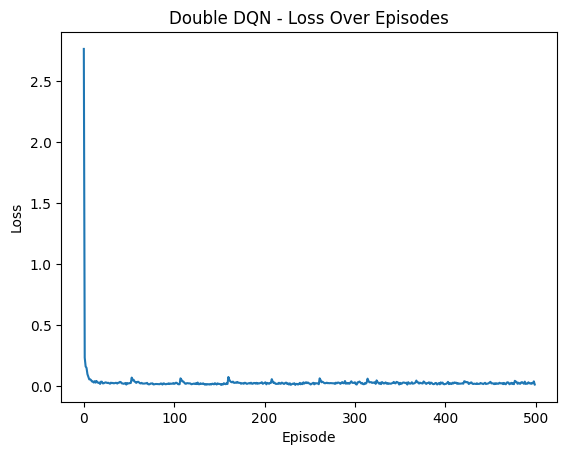

In [6]:
# Plotting loss over episodes
plt.plot(losses_over_episodes)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Double DQN - Loss Over Episodes')
plt.show()


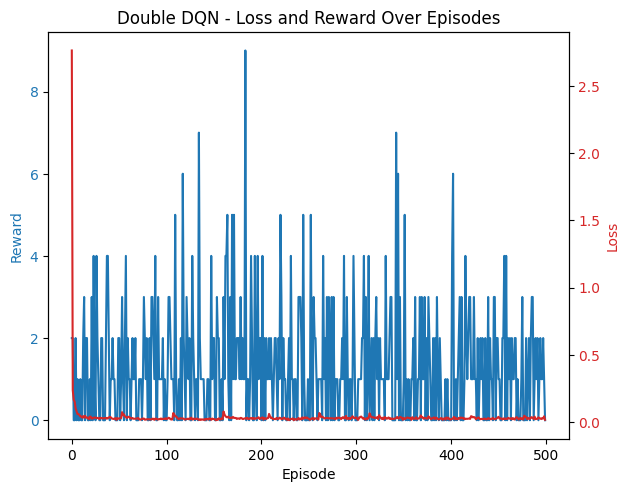

In [7]:
# Plotting loss and reward over episodes
fig, ax1 = plt.subplots()

ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward', color='tab:blue')
ax1.plot(rewards_over_episodes, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(losses_over_episodes, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Double DQN - Loss and Reward Over Episodes')
plt.show()


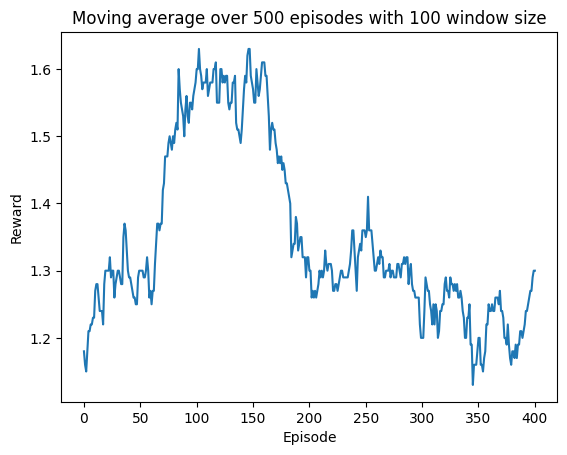

In [8]:
# Plotting moving average of rewards
window_size = 100
moving_avg = np.convolve(rewards_over_episodes, np.ones(window_size)/window_size, mode='valid')

plt.plot(moving_avg)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Moving average over {max_episodes} episodes with {window_size} window size')
plt.show()



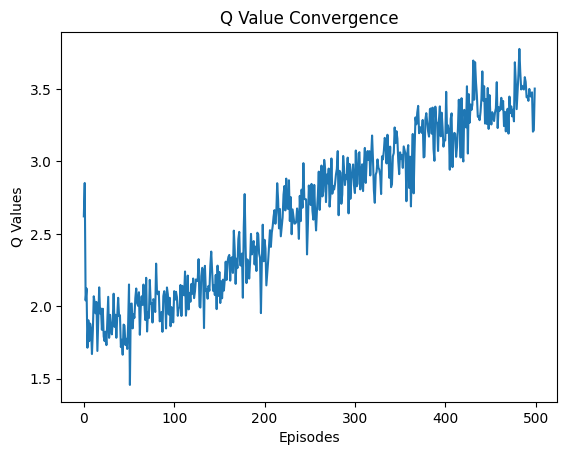

In [9]:
# Plotting Q value convergence
plt.plot(q_values_over_episodes)
plt.xlabel('Episodes')
plt.ylabel('Q Values')
plt.title('Q Value Convergence')
plt.show()

# Double DQN

In [10]:
# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = epsilon_max - epsilon_min  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000
max_episodes = 500  # Limit training episodes, will run until solved if smaller than 1

# Use the Atari environment
env = gym.make("BreakoutNoFrameskip-v4")
env = AtariPreprocessing(env)
env = FrameStack(env, 4)
env.seed(seed)

num_actions = 4

def create_q_model():
    # Network defined by the Deepmind paper
    return keras.Sequential(
        [
            layers.Lambda(
                lambda tensor: tf.transpose(tensor, [0, 2, 3, 1]),
                output_shape=(84, 84, 4),
                input_shape=(4, 84, 84),
            ),
            # Convolutions on the frames on the screen
            layers.Conv2D(32, 8, strides=4, activation="elu", input_shape=(4, 84, 84)),
            layers.Conv2D(64, 4, strides=2, activation="elu"),
            layers.Conv2D(64, 3, strides=1, activation="elu"),
            layers.Flatten(),
            layers.Dense(1024, activation="elu"),
            layers.Dropout(0.1),
            layers.Dense(num_actions, activation="linear"),
        ]
    )

# The first model makes the predictions for Q-values which are used to make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
model_target = create_q_model()

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

rewards_over_episodes = []
q_values_over_episodes = []

# Add a list to store loss values
losses_over_episodes = []

while True:
    observation, _ = env.reset()
    state = np.array(observation)
    episode_reward = 0
    episode_loss = []  # List to store loss for the current episode

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])

            # Build the updated Q-values for the sampled future states
            # Use the main model to select the best action in the next state
            future_action = tf.argmax(model(state_next_sample), axis=1)
            # Use the target model to calculate the Q-value for the best action
            future_rewards = model_target.predict(state_next_sample, verbose=0)
            future_rewards = tf.reduce_max(future_rewards, axis=1)

            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * future_rewards

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Store the loss value
            episode_loss.append(loss.numpy())

        if frame_count % update_target_network == 0:
            # update the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    rewards_over_episodes.append(episode_reward)
    q_values_over_episodes.append(tf.reduce_mean(q_action).numpy())
    losses_over_episodes.append(np.mean(episode_loss))  # Store the average loss for this episode

    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

    if max_episodes > 0 and episode_count >= max_episodes:  # Maximum number of episodes reached
        print("Stopped at episode {}!".format(episode_count))
        break





running reward: 1.09 at episode 55, frame count 10000
running reward: 1.17 at episode 110, frame count 20000
running reward: 1.11 at episode 167, frame count 30000
running reward: 1.27 at episode 218, frame count 40000
running reward: 1.38 at episode 274, frame count 50000
running reward: 1.41 at episode 326, frame count 60000
running reward: 1.35 at episode 380, frame count 70000
running reward: 1.39 at episode 432, frame count 80000
running reward: 1.38 at episode 484, frame count 90000
Stopped at episode 500!


## Results

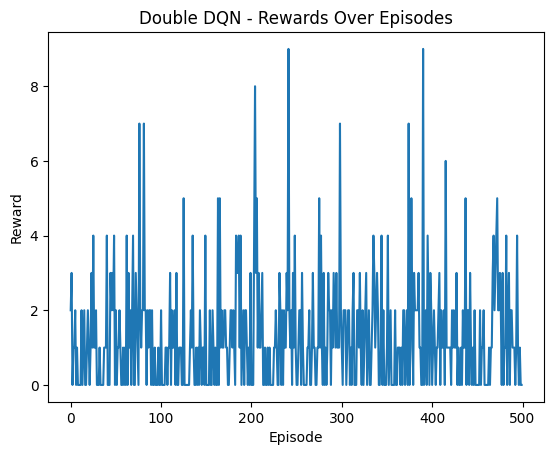

In [11]:
# Plotting rewards over episodes
plt.plot(rewards_over_episodes)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Double DQN - Rewards Over Episodes')
plt.show()

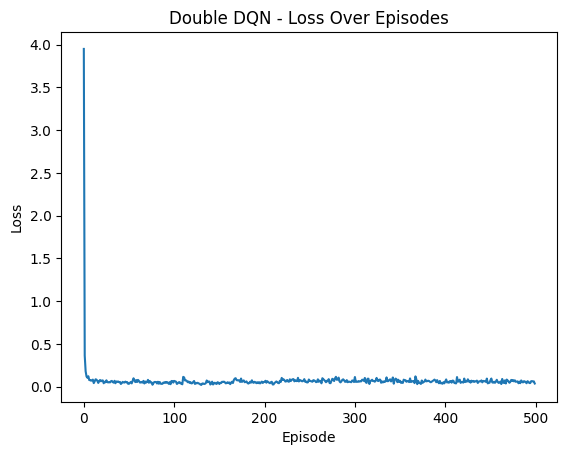

In [12]:
# Plotting loss over episodes
plt.plot(losses_over_episodes)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Double DQN - Loss Over Episodes')
plt.show()




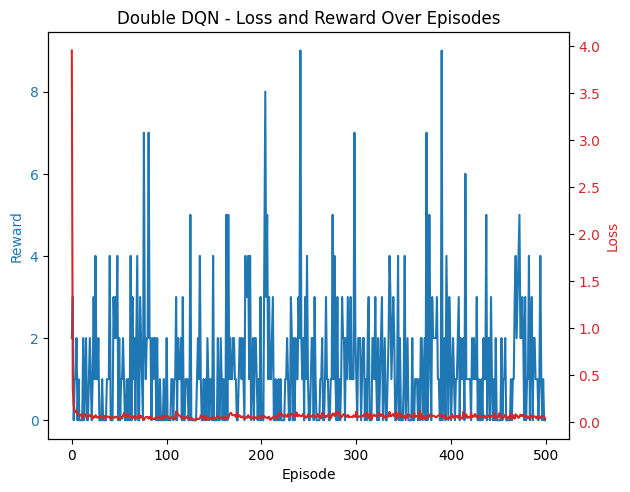

In [13]:
# Plotting loss and reward over episodes
fig, ax1 = plt.subplots()

ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward', color='tab:blue')
ax1.plot(rewards_over_episodes, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(losses_over_episodes, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Double DQN - Loss and Reward Over Episodes')
plt.show()


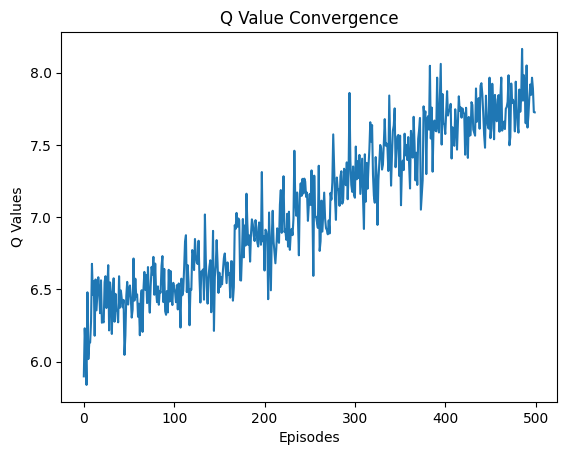

In [14]:

# Plotting Q value convergence
plt.plot(q_values_over_episodes)
plt.xlabel('Episodes')
plt.ylabel('Q Values')
plt.title('Q Value Convergence')
plt.show()


# Dueling DQN

In [15]:
# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = epsilon_max - epsilon_min  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000
max_episodes = 500  # Limit training episodes, will run until solved if smaller than 1

# Use the Atari environment
env = gym.make("BreakoutNoFrameskip-v4")
env = AtariPreprocessing(env)
env = FrameStack(env, 4)
env.seed(seed)

num_actions = 4

def create_dueling_q_model():
    inputs = layers.Input(shape=(4, 84, 84,))
    layer1 = layers.Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(inputs)
    layer2 = layers.Conv2D(32, 8, strides=4, activation='elu')(layer1)
    layer3 = layers.Conv2D(64, 4, strides=2, activation='elu')(layer2)
    layer4 = layers.Conv2D(64, 3, strides=1, activation='elu')(layer3)
    layer5 = layers.Flatten()(layer4)

    layer6 = layers.Dense(1024, activation='elu')(layer5)
    layer7 = layers.Dropout(0.1)(layer6)
    layer8 = layers.Dense(1, activation=None)(layer7)
    # State-Value Stream
    value = layers.Dense(1, activation='linear')(layer8)

    # Advantage Stream
    advantage = layers.Dense(num_actions, activation='linear')(layer8)

    # Aggregating the streams
    q_values = value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))

    return keras.Model(inputs=inputs, outputs=q_values)

# The first model makes the predictions for Q-values which are used to make a action.
model = create_dueling_q_model()
# Build a target model for the prediction of future rewards.
model_target = create_dueling_q_model()

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

rewards_over_episodes = []
q_values_over_episodes = []
losses_over_episodes = []  # List to store the average loss per episode

while True:
    observation, _ = env.reset()
    state = np.array(observation)
    episode_reward = 0
    episode_loss = []  # List to store loss for the current episode

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])

            # Build the updated Q-values for the sampled future states
            # Use the main model to select the best action in the next state
            future_action = tf.argmax(model(state_next_sample), axis=1)
            # Use the target model to calculate the Q-value for the best action
            future_rewards = model_target.predict(state_next_sample, verbose=0)
            future_rewards = tf.reduce_max(future_rewards, axis=1)

            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * future_rewards

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Store the loss value
            episode_loss.append(loss.numpy())


        if frame_count % update_target_network == 0:
            # update the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    rewards_over_episodes.append(episode_reward)
    q_values_over_episodes.append(tf.reduce_mean(q_action).numpy())

    losses_over_episodes.append(np.mean(episode_loss))  # Store the average loss for this episode

    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

    if max_episodes > 0 and episode_count >= max_episodes:  # Maximum number of episodes reached
        print("Stopped at episode {}!".format(episode_count))
        break





running reward: 1.35 at episode 51, frame count 10000
running reward: 1.26 at episode 107, frame count 20000
running reward: 1.45 at episode 156, frame count 30000
running reward: 1.46 at episode 210, frame count 40000
running reward: 1.39 at episode 262, frame count 50000
running reward: 1.39 at episode 316, frame count 60000
running reward: 1.14 at episode 373, frame count 70000
running reward: 1.22 at episode 427, frame count 80000
running reward: 1.09 at episode 486, frame count 90000
Stopped at episode 500!


## Results

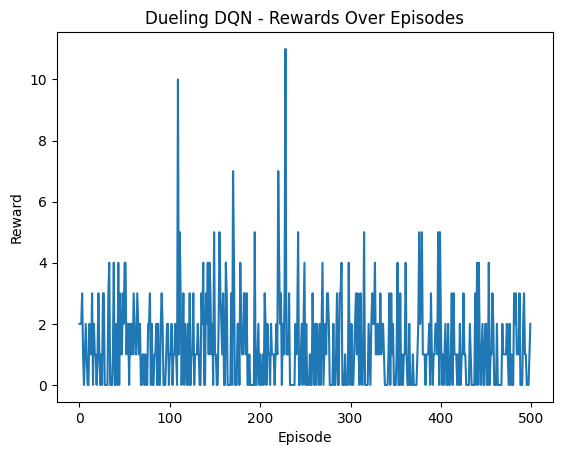

In [16]:
# Plotting rewards over episodes
plt.plot(rewards_over_episodes)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Dueling DQN - Rewards Over Episodes')
plt.show()

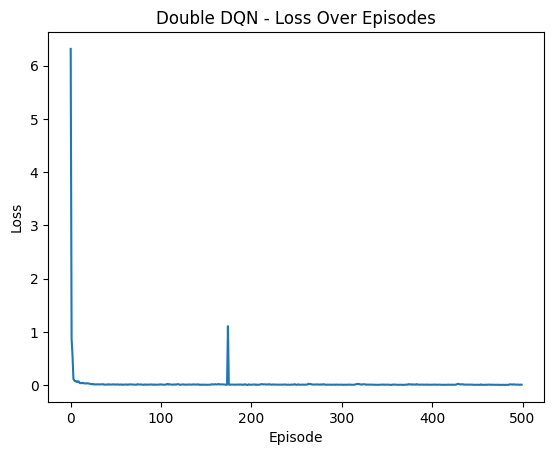

In [17]:
# Plotting loss over episodes
plt.plot(losses_over_episodes)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Dueling DQN - Loss Over Episodes')
plt.show()


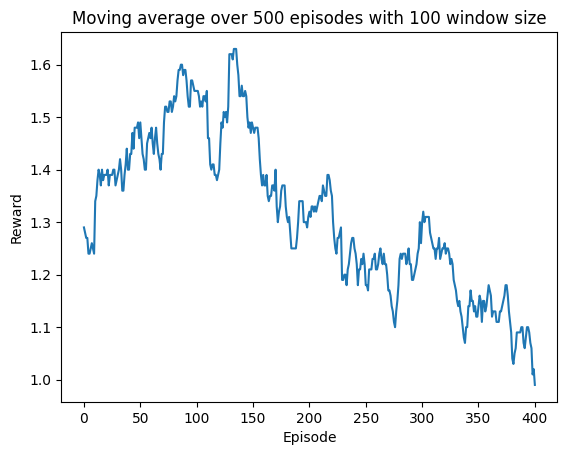

In [18]:
# Plotting moving average of rewards
window_size = 100
moving_avg = np.convolve(rewards_over_episodes, np.ones(window_size)/window_size, mode='valid')

plt.plot(moving_avg)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Moving average over {max_episodes} episodes with {window_size} window size')
plt.show()


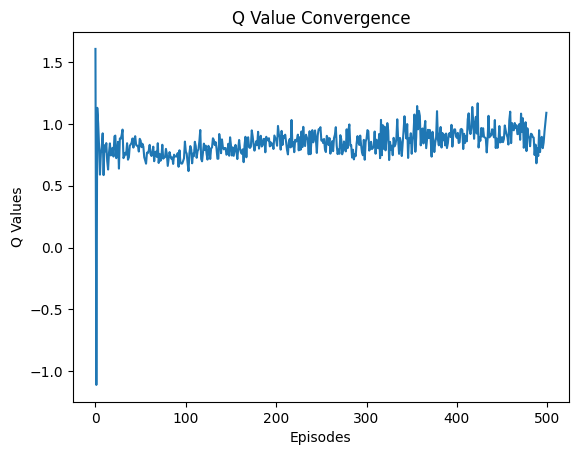

In [19]:

# Plotting Q value convergence
plt.plot(q_values_over_episodes)
plt.xlabel('Episodes')
plt.ylabel('Q Values')
plt.title('Q Value Convergence')
plt.show()


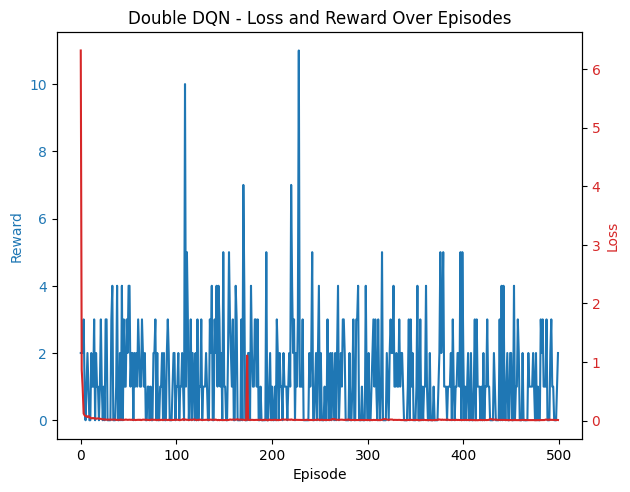

In [20]:
# Plotting loss and reward over episodes
fig, ax1 = plt.subplots()

ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward', color='tab:blue')
ax1.plot(rewards_over_episodes, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(losses_over_episodes, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Dueling DQN - Loss and Reward Over Episodes')
plt.show()


Explanation
Dueling Q Model: The create_dueling_q_model function defines the Dueling DQN architecture, separating the state-value and advantage streams and combining them to produce the Q-values.

Tracking Rewards and Q-values:

rewards_over_episodes: Stores the rewards obtained in each episode.
q_values_over_episodes: Stores the mean Q-values calculated during each update.
Plotting Rewards over Episodes: A simple plot of rewards obtained in each episode.

Plotting Moving Average of Rewards: Calculates the moving average of rewards over a specified window size (e.g., 100 episodes) and plots it.

Plotting Q-value Convergence: A simple plot of mean Q-values over episodes to observe the convergence of Q-values.

You can run this script to train the Dueling DQN model and generate the plots for visualizing the training progress and performance. If you need further adjustments, please let me know!

# Dueling with Prioritized Replay Buffer

In [28]:
# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = epsilon_max - epsilon_min  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000
max_episodes = 500  # Limit training episodes, will run until solved if smaller than 1

alpha = 0.6  # Prioritization exponent
beta_start = 0.4  # Initial value of beta for importance-sampling weight
beta_frames = 100000  # Number of frames over which beta is annealed from initial value to 1
max_memory_length = 100000  # Maximum replay length
update_after_actions = 4  # Train the model after 4 actions
update_target_network = 10000  # How often to update the target network

# Use the Atari environment
env = gym.make("BreakoutNoFrameskip-v4")
env = gym.wrappers.AtariPreprocessing(env)
env = gym.wrappers.FrameStack(env, 4)
env.seed(seed)

num_actions = env.action_space.n
input_shape = (4, 84, 84)

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.pos = 0
        self.alpha = alpha

    def add(self, experience, error):
        max_prio = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience

        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        experiences = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        states, actions, rewards, next_states, dones = zip(*experiences)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones), indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

def create_dueling_q_model(input_shape, num_actions):
    inputs = layers.Input(shape=input_shape)
    layer1 = layers.Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(inputs)
    layer2 = layers.Conv2D(32, 8, strides=4, activation='elu')(layer1)
    layer3 = layers.Conv2D(64, 4, strides=2, activation='elu')(layer2)
    layer4 = layers.Conv2D(64, 3, strides=1, activation='elu')(layer3)
    layer5 = layers.Flatten()(layer4)

    layer6 = layers.Dense(1024, activation='elu')(layer5)
    layer7 = layers.Dropout(0.1)(layer6)
    layer8 = layers.Dense(1, activation='linear')(layer7)
    # State-Value Stream
    value = layers.Dense(1, activation='linear')(layer7)

    # Advantage Stream
    advantage = layers.Dense(num_actions, activation='linear')(layer8)

    # Aggregating the streams
    q_values = value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))

    return keras.Model(inputs=inputs, outputs=q_values)

# The first model makes the predictions for Q-values which are used to make a action.
model = create_dueling_q_model(input_shape, num_actions)
# Build a target model for the prediction of future rewards.
model_target = create_dueling_q_model(input_shape, num_actions)

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Using huber loss for stability
loss_function = keras.losses.Huber()

rewards_over_episodes = []
q_values_over_episodes = []
losses_over_episodes = []  # List to store the average loss per episode

# Initialize the prioritized replay buffer
replay_buffer = PrioritizedReplayBuffer(max_memory_length, alpha)

running_reward = 0
episode_count = 0
frame_count = 0
epsilon = epsilon_max
episode_reward_history = []

while True:
    observation,_ = env.reset()  # Updated to handle single return value
    state = np.array(observation)
    episode_reward = 0
    episode_loss = []  # List to store loss for the current episode

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _,_ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Calculate the TD error for the transition
        state_tensor = tf.convert_to_tensor(np.expand_dims(state, axis=0), dtype=tf.float32)
        state_next_tensor = tf.convert_to_tensor(np.expand_dims(state_next, axis=0), dtype=tf.float32)
        future_action = tf.argmax(model(state_next_tensor), axis=1)
        future_rewards = model_target(state_next_tensor)
        future_rewards = tf.reduce_max(future_rewards, axis=1)
        target_q = reward + gamma * future_rewards.numpy()[0] * (1 - done)
        current_q = model(state_tensor)[0][action].numpy()
        td_error = abs(target_q - current_q)

        # Save actions and states in replay buffer with TD error as priority
        replay_buffer.add((state, action, reward, state_next, done), td_error)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(replay_buffer.buffer) > batch_size:
            # Beta increases linearly from beta_start to 1
            beta = min(1.0, beta_start + frame_count * (1.0 - beta_start) / beta_frames)

            # Sample from the replay buffer
            states, actions, rewards, next_states, dones, indices, weights = replay_buffer.sample(batch_size, beta)

            weights = tf.convert_to_tensor(weights, dtype=tf.float32)

            # Calculate updated Q-values
            future_action = tf.argmax(model(next_states), axis=1)
            future_rewards = model_target.predict(next_states, verbose=0)
            future_rewards = tf.reduce_max(future_rewards, axis=1)

            updated_q_values = rewards + gamma * future_rewards * (1 - dones)
            updated_q_values = tf.convert_to_tensor(updated_q_values, dtype=tf.float32)

            masks = tf.one_hot(actions, num_actions)

            with tf.GradientTape() as tape:
                q_values = model(states)
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = loss_function(updated_q_values, q_action)
                loss *= weights  # Apply weights to the loss
                loss = tf.reduce_mean(loss)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Update priorities in the replay buffer
            updated_priorities = abs(updated_q_values.numpy() - q_action.numpy()) + 1e-6
            replay_buffer.update_priorities(indices, updated_priorities)

            # Store the loss value
            episode_loss.append(loss.numpy())

        if frame_count % update_target_network == 0:
            # update the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        if len(replay_buffer.buffer) > max_memory_length:
            replay_buffer.buffer.pop(0)
            replay_buffer.priorities = np.delete(replay_buffer.priorities, 0)

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    rewards_over_episodes.append(episode_reward)
    q_values_over_episodes.append(tf.reduce_mean(q_action).numpy())
    losses_over_episodes.append(np.mean(episode_loss))  # Store the average loss for this episode

    # print(f"Episode {episode_count} - Reward: {episode_reward}, Avg Loss: {np.mean(episode_loss)}")

    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

    if max_episodes > 0 and episode_count >= max_episodes:  # Maximum number of episodes reached
        print("Stopped at episode {}!".format(episode_count))
        break


running reward: 1.83 at episode 48, frame count 10000
running reward: 1.56 at episode 101, frame count 20000
running reward: 1.30 at episode 154, frame count 30000
running reward: 1.22 at episode 208, frame count 40000
running reward: 1.35 at episode 259, frame count 50000
running reward: 1.34 at episode 315, frame count 60000
running reward: 1.13 at episode 371, frame count 70000
running reward: 1.10 at episode 427, frame count 80000
running reward: 1.01 at episode 484, frame count 90000
Stopped at episode 500!


## Results

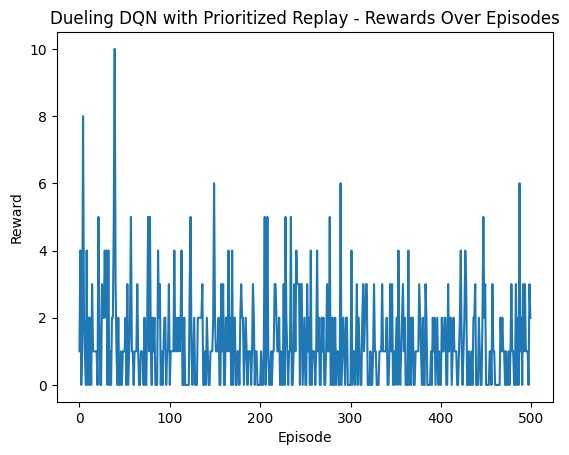

In [29]:
# Plotting rewards over episodes
plt.plot(rewards_over_episodes)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Dueling DQN with Prioritized Replay - Rewards Over Episodes')
plt.show()


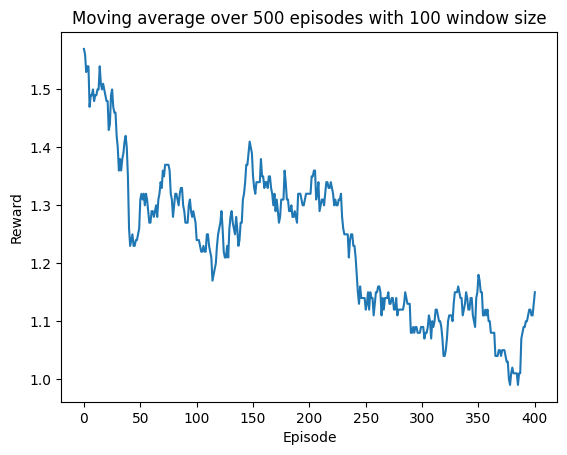

In [30]:
# Plotting moving average of rewards
window_size = 100
moving_avg = np.convolve(rewards_over_episodes, np.ones(window_size)/window_size, mode='valid')

plt.plot(moving_avg)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Moving average over {max_episodes} episodes with {window_size} window size')
plt.show()


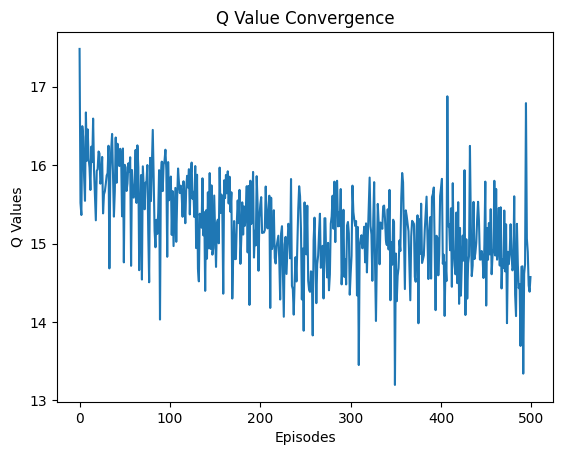

In [31]:

# Plotting Q value convergence
plt.plot(q_values_over_episodes)
plt.xlabel('Episodes')
plt.ylabel('Q Values')
plt.title('Q Value Convergence')
plt.show()

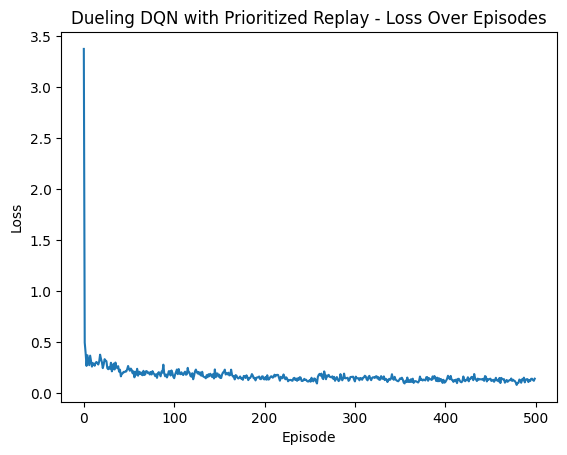

In [32]:
# Plotting loss over episodes
plt.plot(losses_over_episodes)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Dueling DQN with Prioritized Replay - Loss Over Episodes')
plt.show()



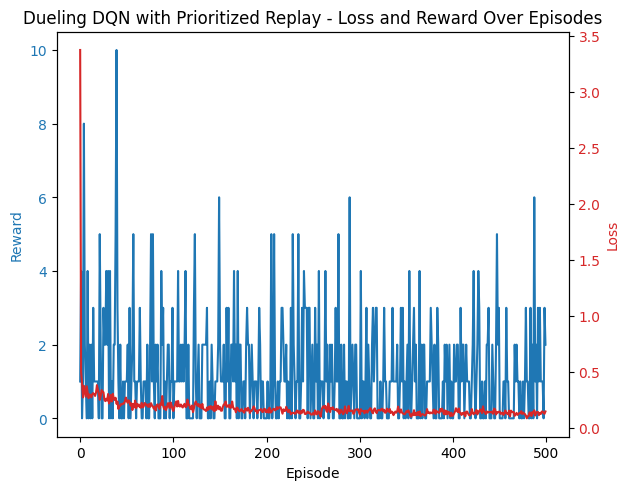

In [33]:
# Plotting loss and reward over episodes
fig, ax1 = plt.subplots()

ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward', color='tab:blue')
ax1.plot(rewards_over_episodes, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(losses_over_episodes, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Dueling DQN with Prioritized Replay - Loss and Reward Over Episodes')
plt.show()